# The Grestest Senstivity Mapper Demo

This demo will consist of three examples for runing the sensitivity mapper.
1. Setting up a map by hand
2. Reading in an AOR file of the same map created in USPOT
3. Comparing a single pointing to SITE


First we import the required python libraries

In [1]:
import sens_map_lib #main library for the sensitivity mapper
import numpy as np #numpy
from astropy.modeling import models #For generating synthetic signal on the sky
from matplotlib import pyplot as plt #For plotting

## Demo 1 - A total power array OTF [C II] map of a galaxy

Here we will create an array OTF map of the [C II] line in a galaxy. 

The first step is to set up an object of the `sky` class.  The `sky` class is a wrapper for the 2D array of pixels that represent the spatially resolved signal, exposure, data, and noise on the sky.    Pixel coordinates are in arcseconds.  In general, a `sky` object needs to be big enough to cover your maps.  Pixel sizes should start out small (~0.1"-1") which can be later regridded to larger pixel sizes. Note that larger maps or smaller plate scales will be more computationally intensive.

In this demo, we will set up a 400"x400" `sky` object with a 1" spatial resolution.  The first argument is range of the x axis, the second argument is the range of the y axis, and the third argument is the spatial resolution or "plate scale".  All units are in arcsec.

In [2]:
skyobj = sens_map_lib.sky([-200.0,200.0], [-200.0, 200.0], 1.0) #Generate sky object

Next we want to define what we expect the signal on the sky to be.  You can use the `uniform` method to give the sky a constant signal.  You can also use the `input` method to input astropy models (see https://docs.astropy.org/en/stable/modeling/reference_api.html#pre-defined-models) of various shapes.

For this demo, we will draw an ellipse with a $T_a = 0.5 K$ using an astropy model and input it into the `sky` object using the `input` method.  This will be a crude representation of how [C II] emission might look from a disk galaxy.  We then plot the resulting assumed signal using `plot('signal')` to see what it looks like.

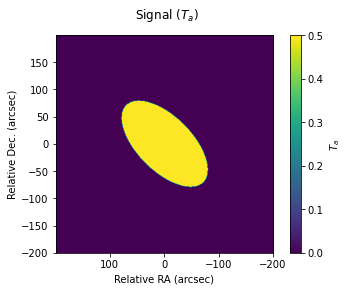

In [3]:
ellipse = models.Ellipse2D(amplitude=0.5, x_0=0.0, y_0=0.0, a=100, b=50, theta=np.pi/4.0) #Generate 2D ellipse using an astropy model that will be our galaxy
skyobj.input(ellipse) #Input 2D ellipse into skyobj
skyobj.plot('signal') #Plot the resulting assumed signal on the sky

Now we are going to set up the array object for the LFA to observe the [C II] line.  The `GREAT_array` class stores the array profiles, FWHMs and other information for the LFA, HFA, and 4GREAT array and beams.  It has the following child classes:
* `LFAH_array` - LFA array horizontal polarization
* `LFAV_array` - LFA array vertical polarization (currently identical to above)
* `HFA_array` - HFA array
* `FG1_array` - 4GREAT 1
* `FG2_array` - 4GREAT 2
* `FG3_array` - 4GREAT 3
* `FG4_array` - 4GREAT 4


Note that there are actually two LFA arrays for two different polarizaitons.  LFAH and LFAV.  Here we will use `LFAH_array` child class of `GREAT_array`, but remember each observation is repeated twice if you combine botht LFAH and LFAV together.  The simplest way of dealing with this is to double the exposure time.  The line frequency is also set here and represents the frequency the array is tuned to.  The [C II] line lies at 1.9005369 THaz.



In [4]:
lfa_array = sens_map_lib.LFAH_array(freq=1.9005369e12) #Define array object

Each array object has the following mapping methods.  The first argument passed is always the `sky` object.  Below we also list all the other arguments based on which map you are using.

* `single_point`
 * `x` (center x position)
 * `y` (center y position)
 * `time` (exposure time)
 * `cycles` (number of cycles)
 * `array_angle` (angle of array in degrees)
* `map` (this is for both raster and regular OTF maps)
 * `x` (center x position)
 * `y` (center y position)
 * `nx` (number of steps in x direction)
 * `ny` (number of steps in y direction)
 * `dx` (size of step in x direction in arcsec)
 * `dy` (size of step in y direction in arcsec)
 * `time` (exposure time)
 * `cycles` (number of cycles)
 * `array_angle` (angle of array in degrees)
 * `map_angle` (angle of map in degrees)
* `honeycomb`
 * `x` (center x position)
 * `y` (center y position)
 * `time` (exposure time)
 * `cycles` (number of cycles)
 * `array_angle` (angle of array in degrees)
 * `map_angle` (angle of map in degrees)
 * `LFA` (Set = True to force LFA honeycomb map, normally this is automatic and you can ignore it)
 * `HFA` (Set = True to force HFA honeycomb map, normally this is automatic and you can ignore it)
* `array_otf`
 * `nblock_scan` (number of blocks in the scan direction)
 * `nblock_prep` (number of blocks perpendicular to the scan direction)
 * `x` (center x position)
 * `y` (center y position)
 * `step` (size of step in scan direction in arcsec)
 * `length` (length of a block in the scan dir3ection in multiples of the array size)
 * `time` (exposure time)
 * `cycles` (number of cycles)
 * `map_angle` (angle of map in degrees)
 * `direction` (direction of the array OTF map as 'x' or 'y')
 * `nscans` (number of scans in a single block)


For this demo, we will be creating a total power array OTF map. See above for what arguments are what.  Running the `array_otf` method will save the necessary beam/map information into `skyobj` (which is always passed as the first argument) which will be used to simulate the observation in the next step. 

In [5]:
lfa_array.array_otf(skyobj, nblock_scan=4, nblock_perp=3, x=0.0, y=0.0, step=5.2, length=1.0,
                        time=5.0, cycles=10, map_angle=315.0, direction='x', nscans=2)

Now it is time to simulate the observation, but before we can do that we must get the system temperaturte ($T_{sys}$) from SITE 

* Go to SITE: https://dcs.arc.nasa.gov/proposalDevelopment/SITE/index.jsp
* Under Spectroscopic Time Estimators and Tools select GREAT
* You can leave everything as default since it is already on the [C II] line and we are only interested in $T_{sys}$
* Click Calculate

In general we use the sideband with the lowest system temperature and in this demo we get `Single Sideband System Temperature (USB tuning) 2618 K`. 

Now to simulate the observations, we use the `simulate_object` method.  This will generate the resulting exposure, noise, and data maps.  Here we input the system temperature as `Tsys` and the spectral resolution either as `deltafreq` in Hz or `deltav` in km/s.  Here we input 2618 K the system temperature and 1 km/s for the spectral resolution.  Since this is a total power OTF map, we must also set `TPOTF=True`.  For proper noise calculations of a TP OTF map (see the observers handbook for more details), we also set `Non` which here is set to `Non=10`.

In [6]:
skyobj.simulate_observation(Tsys=2618.0, deltav=1.0, TPOTF=True, Non=10)

Total beam signal: 292.42167785591624
Total beam noise: 19243.2463020364
Total beam S/N: 0.015196067922540229
total signal = 7858.9671694780545
total noise =  inf
Total S/N:  0.0


/Users/kkaplan1/Desktop/the_greatest_sensitivity_mapper/sens_map_lib.py:396: RuntimeWarning: invalid value encountered in true_divide
  self.data = self.data / (self.exptime) #normalize simulated data by exposure time
/Users/kkaplan1/Desktop/the_greatest_sensitivity_mapper/sens_map_lib.py:399: RuntimeWarning: divide by zero encountered in true_divide
  self.noise = noise  / ((self.exptime)**0.5)
/Users/kkaplan1/Desktop/the_greatest_sensitivity_mapper/sens_map_lib.py:426: RuntimeWarning: overflow encountered in square
  total_noise = bn.nansum(self.noise[goodpix]**2)**0.5


Now we will plot our results.

Below is the spatially resolved exposure time showing the array OTF map.  The red dots show the centers of the individual array OTF blocks.  The exposure map is created by treating the expoisure time for each beam (or step) in a map as a point source and convolutionally regridding the exposure time onto the sky using a kernel that is 1/3 the FWHM of the beam FWHM.

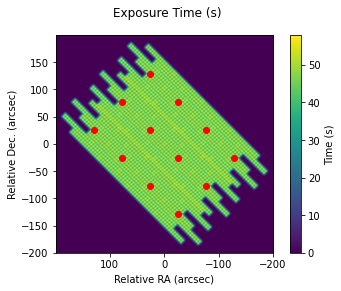

In [7]:
skyobj.plot('exposure')

Now we will plot the noise map.  The noise is calculated using the same equations as SITE, except we apply it to the spatially resolved exposure time map.  Since GREAT/SOFIA is background limited, we do not need to take into account the poisson noise from the signal.  The noise map looks like a negative of the exposure time map.  The noise is lowest at the center of each beam and quickly goes up the further away you are from the beam center.  A map such as this will typically produce a uniform noise level within the confines of the map.  We will also print the minimum noise so you can see the value.

Min. noise =  0.15694262191071323


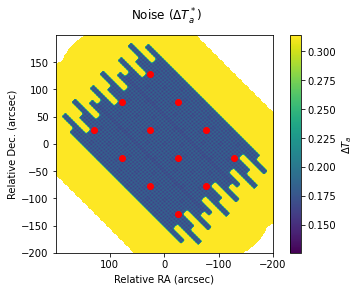

In [8]:
skyobj.plot('noise')
print('Min. noise = ', np.nanmin(skyobj.noise))

Next will will re-plot the assumed signal and then the simualted data for comparison.  The signal we defined at the beginning is convolved with the profile of each beam at each step in the map to determine how much signal the beam at each step picks up, the resulting singals detected by each step are then convolutionally regridded back onto the sky and the result is this data map.  As you can see, the simulated data map strongly resembles the signal map, but with the sharp edges blurred due to the limited spatial resolution of the instrument.

<Figure size 432x288 with 0 Axes>

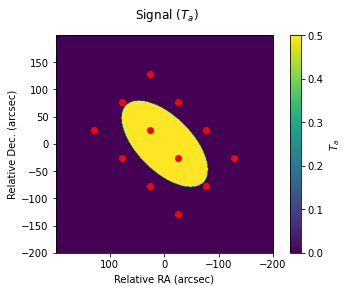

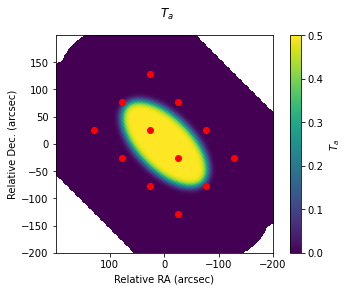

<Figure size 432x288 with 0 Axes>

In [9]:
plt.figure()
skyobj.plot('signal')
plt.figure()
skyobj.plot('data')
plt.figure()

We can also plot the spatially resolved signal-to-noise.

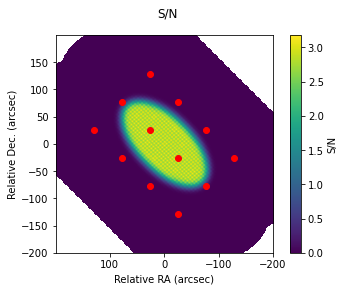

In [10]:
skyobj.plot('s2n')

We can downsample these maps using the `downsample` method of the `sky` object for a given factor to multiply the plate scale by.  Downsampling can be used to make the maps resemble the actual spatial resolution of data in Class.  In this example, we downsample by a factor of five which changes the plate scale from 1" to 5".  

total signal = 314.3586867791255
total noise =  1.0550656698367555e+152
Total S/N:  3.724397160365436e-152


/Users/kkaplan1/conda/anaconda3/lib/python3.8/site-packages/skimage/measure/block.py:76: RuntimeWarning: Mean of empty slice
  return func(blocked, axis=tuple(range(image.ndim, blocked.ndim)))
/Users/kkaplan1/Desktop/the_greatest_sensitivity_mapper/sens_map_lib.py:419: RuntimeWarning: overflow encountered in square
  self.noise = block_reduce(self.noise**2, factor, func=np.nanmean)**0.5 / factor #Note the 1/factor is actually 1/sqrt(factor*^2) since factor^2 is the number of pixels being averaged together


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

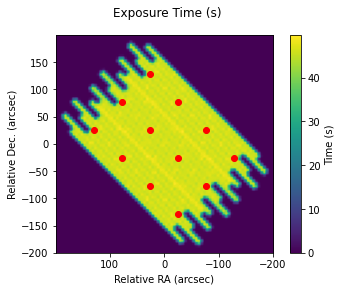

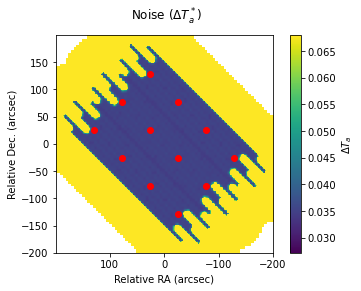

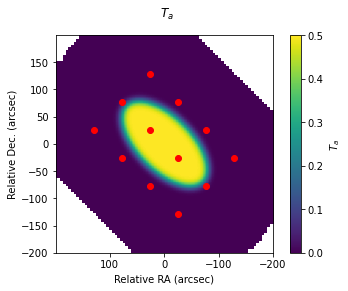

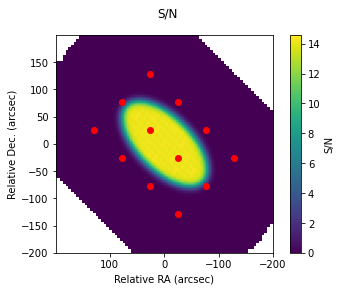

In [11]:
skyobj.downsample(5)

plt.figure()
plt.figure('signal')
plt.figure()
skyobj.plot('exposure')
plt.figure()
skyobj.plot('noise')
plt.figure()
skyobj.plot('data')
plt.figure()
skyobj.plot('s2n')

In the next demo, we will rerun the same example but this time using a .aor file to automate much of the process.

## Demo 2 - A total power array OTF [C II] map of a galaxy read from a .aor file

This demo is exactly the same as the previous one except we read in a .aor file storing the AOR of the total power OTF map we want to make.

First let us set up the `sky` object with the expected signal.


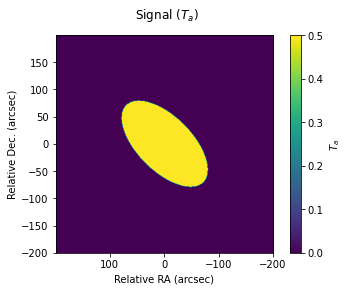

In [12]:
skyobj = sens_map_lib.sky([-200.0,200.0], [-200.0, 200.0], 1.0) #Generate sky object
ellipse = models.Ellipse2D(amplitude=0.5, x_0=0.0, y_0=0.0, a=100, b=50, theta=np.pi/4.0) #Generate 2D ellipse using an astropy model that will be our galaxy
skyobj.input(ellipse) #Input 2D ellipse into skyobj
skyobj.plot('signal') #Plot the resulting assumed signal on the sky

We have prepared an AOR already in `demo.aor`.  You can open it in USPOT to check that it matches the total power array OTF map parameters from the previous demo.

We open .aor files with `sens_map_lib.open_aors(filename.aor)`.   This will generate a list of objects of the `aor` class, here called `aors`.  There is only one AOR in the `demo.aor` file so there is only one AOR in this list.  To put the map from the AOR into the `sky` object, we use the `paint` method where the first argument is the `sky` object and the second argument is the GREAT array type ('LFAH', 'LFAV', 'HFA', '4G1', '4G2', '4G3', or '4G4').  We then run `simulate_observation` on the `sky` object, again putting in the system temperature from SITE of 2618 K and the spectral resolution of 1 km/s like before.

In [13]:
aors = sens_map_lib.open_aors('demo.aor')
aors[0].paint(skyobj, 'LFAH')
skyobj.simulate_observation(Tsys=2618.0, deltav=1.0)

Total beam signal: 292.42167785591624
Total beam noise: 19259.045298187946
Total beam S/N: 0.015183601955774503
total signal = 7858.9671694780545
total noise =  inf
Total S/N:  0.0


Finally we downsample and then plot the results.  As you can see, they are identical to the previous demo.  Using AORs greatly streamlines the process!

total signal = 314.3586867791255
total noise =  1.0559318947031836e+152
Total S/N:  3.721341882417165e-152


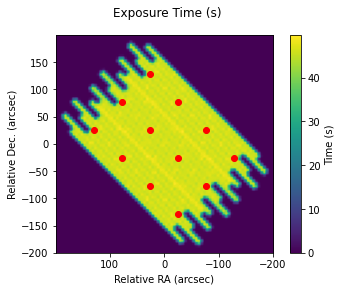

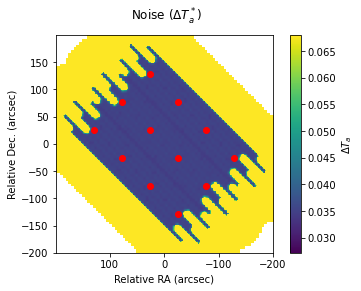

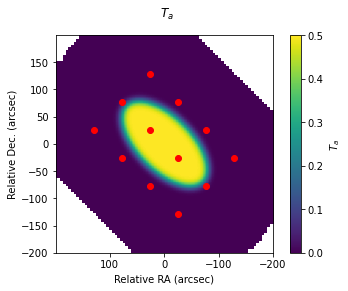

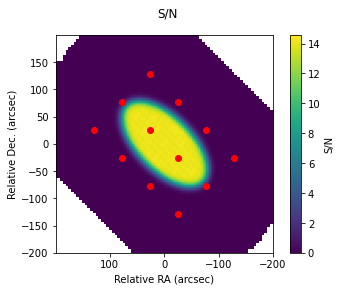

In [14]:
skyobj.downsample(5)

plt.figure()
skyobj.plot('exposure')
plt.figure()
skyobj.plot('noise')
plt.figure()
skyobj.plot('data')
plt.figure()
skyobj.plot('s2n')

## Demo 3 - A single pointing and comparison to SITE for an HFA observation of the [O I] line

Here we will run a single pointing.  We will use SITE to get our noise estimate and also we will compare our results to SITE.  If everything runs correctly, SITE and the sensitivty mapper should give us the same result.

Below we define a sky object that is 60"x60" centered at zero with a pixel size of 0.5".  The first arguments give the range of x and y in arcsec and the third argument is the pixel size or plate scale.

In [15]:
skyobj = sens_map_lib.sky([-30.0,30.0], [-30.0, 30.0], 0.5)

A sky object consists of four 2D arrays that store the following:
1. Signal
2. Exposure
3. Noise
4. Data

The first step is to define what we think the signal on the sky looks like.  This will populate the `signal` array.  Since this is a single pointingm, we will give the sky a uniform background of $T_a = 5 K$.  For uniform signals, there is a special `signal` method.  You can explicitely define what you think the signal on the sky is by setting `skyobj.signal =`.  Astropy models work well for this.

In [16]:
skyobj.uniform(5.0)

Now we will plot the signal for `skyobj` with a special `plot` argument.  Note the spatial coordinates are 60"x60" centered at 0,0 and the signal is a uniform 5 K, exactly as we defined. 

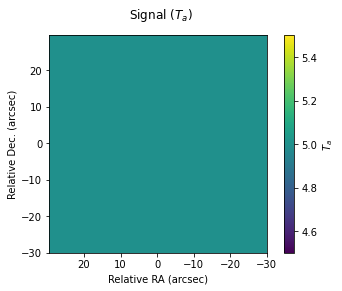

In [17]:
skyobj.plot('signal')

Since we want to simualte a single pointing observation with the HFA, we need to set up a `GREAT_array` object for the HFA.  GREAT_array has child classes for each array.  Here we will set up the HFA child class `HFA_array`.  We also will explicitely define the freqeuncy of the line in Hz here.  Later we will see how we can read in AORs which will handle creating `GREAT_array` object automatically.

In [18]:
hfa_array = sens_map_lib.HFA_array(freq=4.74477749e12)

Now we will define our observation by passing `skyobj` to `hfa_array` with the `single_point` method.  This passes the necessary information about this pointing/map to `skyojb` for later processing.  You can reapeat this for as many pointings or maps as necessary, but for this demo we just going to define a single pointing at an RA and Dec of 0,0 with an exposure time of 100 seconds and 1 cycle.  We will not rotate the array angle.

In [19]:
hfa_array.single_point(skyobj, x=0., y=0., array_angle=0., time=100.0, cycles=1)

Next we will figure out the noise level.  In order to do this we need the system temperature $(T_{sys})$ which can be calculated using the SOFIA Instrument Time Estimator (SITE).  For now we will use SITE to estimate $T_{sys}$ but keep it open because we will be comparing our final results to SITE at the end.

Do the following:
 * Go to SITE: https://dcs.arc.nasa.gov/proposalDevelopment/SITE/index.jsp
 * Under Spectropic Time Estimators and Tools, select GREAT
 * Set the rest frequency to 4.7447749 THz, which is the frequency for the HFA tuned to the [O I] line
 * Leave the Frequency/Velocity Resolution at 1.0 km/s
 * Leave the Line Width at 500.0 MHz
 * Set the Type of Observation to SinglePoint or BeamSwitch OTF/Raster Map
 * Leave Observer Velocity at 0.0 km/s
 * Set the Calculation Method to Total Integration Time and set the time to 100.0 seconds
 * Under Astronomical Source Definition, set the Bright Temprature $T_R^*(K)$ to 5.0 and leave the Source Velocity 0.0 km/s
 * Leave the Observing Condition Constraints as their default, 40 degree Elevation Angle, an Altitude of 41000 feet, and the Zenith Water Vapor set to 7.3 um.
 
SITE should look like this:
 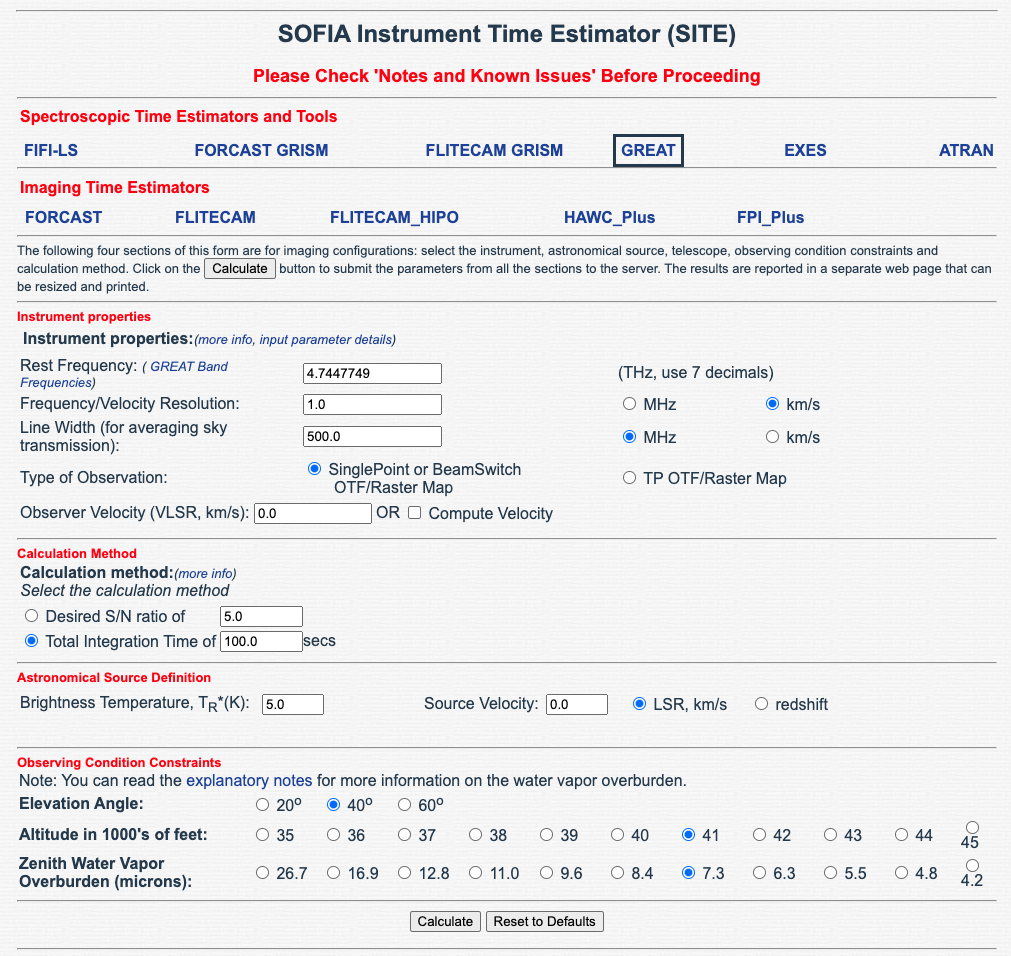

 
Now click Calculate, the resulting page should look like this:
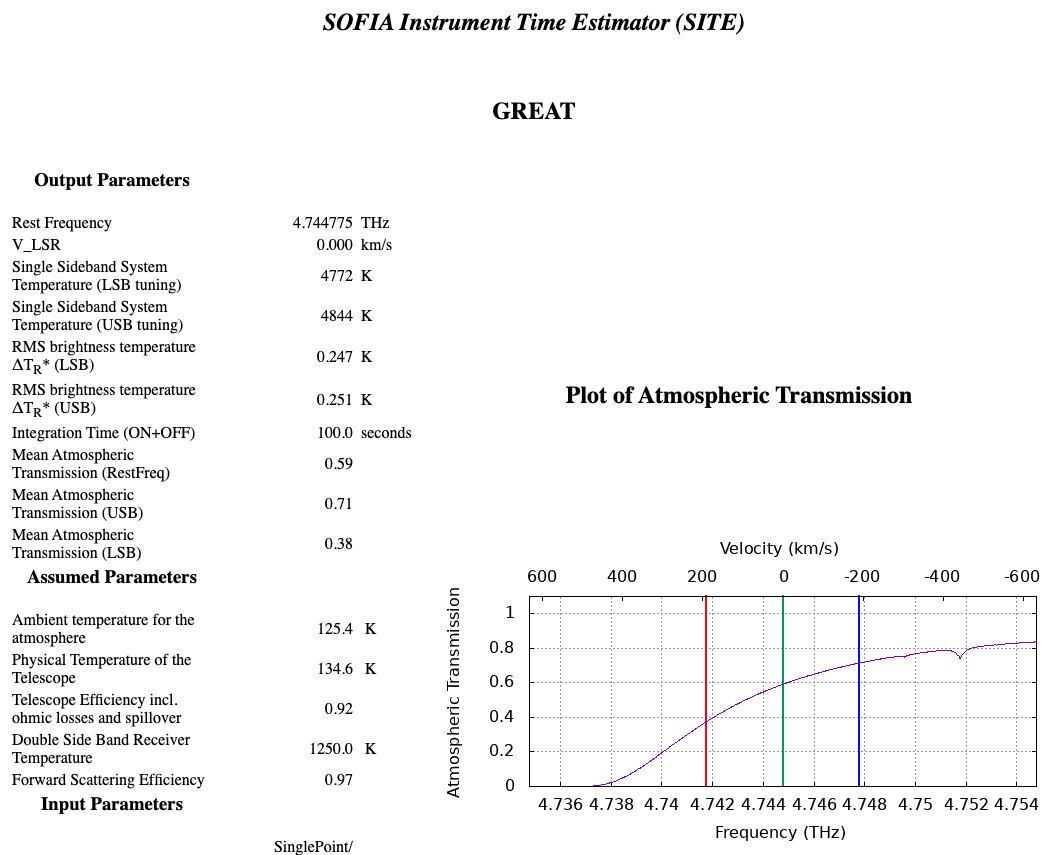
As you can see, the [O I] line lies on the edge of a large telluric absorption feature (we will come back to this later).  Here we will use the Single Side System Temperature (LSB tuning) of 4772 K which we set in skyobj as follows.

Now that we have our noise level, we will simulate the observations using the `simulate_observation` method of `skyobj`, which will take all the information on the pointings fed to `skyobj` by `hfa_array` and generate the resulting exposure, noise, and data maps.  This is where we set the noise level $T_{sys} = 4772 K$.  We also set our spectral resolution element here with either the `deltafreq` or `deltav` command which sets the resolution in Hz or km/s respectively.  Here we set `deltav=1.0` for 1 km/s resolution.

In [20]:
skyobj.simulate_observation(Tsys = 4772.0, deltav=1.0)

Total beam signal: 34.99999999999992
Total beam noise: 4.443036866101191
Total beam S/N: 7.877494843006507
total signal = 72000.0
total noise =  1.5575815082360934e+118
Total S/N:  3.852125855548189e-116


Now let us look at the exposure map which gives the spatially resolved exposure time

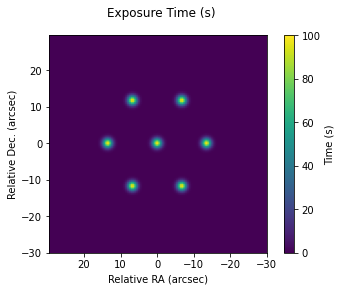

In [21]:
skyobj.plot('exposure')

Here you can see the hexagonal footprint of the seven HFA beams on the sky.  The exposure map is created by treating each beam as a point source with the given exposure time  and convolutionally regridding it onto the sky using a kernal that is a gaussian with 1/3 the FWHM of the beam size.  One thing to keep in mind is that because there are seven beams, the total exposure here is really 7x that of the calculations used on SITE.

Now let us look at the noise map.

Min. noise =  0.2399014410937864


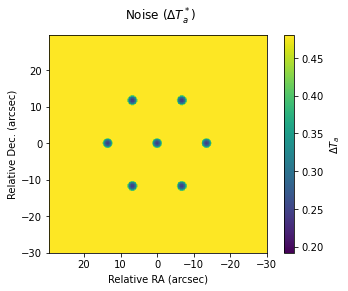

In [22]:
print('Min. noise = ', np.min(skyobj.noise))
skyobj.plot('noise')

The noise is calculated using the same equations as SITE, except we apply it to the whole exposure time map instead of a single beam.  Since GREAT/SOFIA is background limited, we do not need to take into account the poisson noise from the signal.  The noise map looks like a negative of the exposure time map.  The noise is lowest at the center of each beam and quickly goes up the further away you are from the beam center.  Here we also print the minimum noise so you can see what it is at the center of each beam on the sky.

What about the data?  The signal we defined at the beginning is convolved with the profile of each beam to determine how much signal each beam picks up, the resulting singals detected by each beam are then convolutionally regridded back onto the sky and the result is this data map.

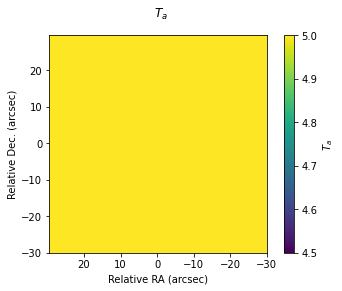

In [23]:
skyobj.plot('data')

As you can see, the result is uniform and $T_a = 5 K$ just like the signal we inputted.  This is exactly what we would expect.

What is our signal-to-noise ratio?  We can make a S/N map by dividing the `data` by the `noise`.  The `skyobj` already has this built into its plotting function as you can see.

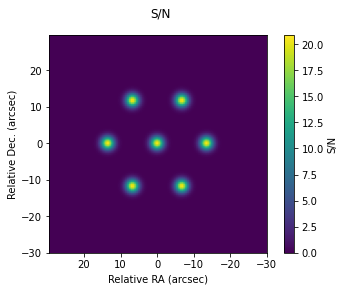

In [24]:
skyobj.plot('s2n')

The peak S/N is about 20.0. 

NOTE: When dealing with S/N maps, one must distinguish between the spatially resolved S/N and the integrated S/N.  Integrating the S/N for a map requires careful consideration of how you mask out unwanted pixels.  Schemes such as optimal extraction or Voronoi binning might also work.  Bad masks will include pixels with lots of noise (remember the noise increases to infinity outside any beam profile coverage) leading to very low integrated S/N measurements.

Now let us compare to the results from SITE which gives the following
RMS brightness temperature ΔTR* (LSB) = 0.247 K.
Again we take the minimum of the noise map.

In [25]:
print('Min noise: ', np.min(skyobj.noise))

Min noise:  0.2399014410937864


You can see the noise is slighgtly higher for SITE.  This is likely due to this program assuming perfect telescope efficiency, while SITE includes a correction factor.

Now let us compare our exposure time to what is calculated on SITE.  We have a max S/N of:

In [26]:
print('Max S/N = ', np.max(skyobj.data/skyobj.noise))

Max S/N =  20.8418923087889


Go back to SITE and change the Calculation Method from Total Integration Time to Desired S/N and set it to 20.8.
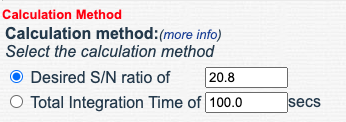



This results in an estimated integration time of 105.9 seconds.
which is very close to our 100.0 second integration time.
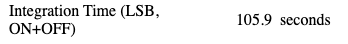

We have demonstraited in this demo that for a single pointing, both SITE and this program give almost the same results, ignoring small losses due to telescope efficiency or atmospheric transmission.  In the next demo, we will walk through creating a map.